In [1]:
######################################################################################
###
###            " Phenotype structuring in collective cell migration:
###                a tutorial of mathematical models and methods "
###
###                 T. Lorenzi, K.J. Painter, C. Villa (2025)
###
### Contact: C. Villa at < chiara.villa@inria.fr >
###
######################################################################################
###
### Code to solve the PDE (69) in Lorenzi et al. (2025) with the method outlined in
### Section 4.3 of the tutorial, for diffusion-driven motion:
###
### \dt n = \dx [ D(y)*\dx n - A(y,\rho,S)*n ] + \bar{D} \d2yy n + n*R(y,\rho,S)
### \rho(t,x) = \int_0^1 n(t,x,y) dy
###
### Diffusion-driven motion: 
### D(y) = Diffx * y ;    A(y,\rho,S) = 0 ;    R(y,\rho,S) = r*(1-y-\rho)
### 
######################################################################################
###
### Copyright (C): K.J. Painter and C. Villa
###
### This program is free software: you can redistribute it and/or modify it under the
### terms of the GNU General Public License as published by the Free Software 
### Foundation, either version 3 of the License, or (at your option) any later version. 
###
### This program is distributed in the hope that it will be useful, but WITHOUT ANY
### WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A 
### PARTICULAR PURPOSE.  See the GNU General Public License for more details.
###
### You should have received a copy of the GNU General Public License along with this
### program.  If not, see <https://www.gnu.org/licenses/>.
###
######################################################################################

In [ ]:
### Main code to solve system and plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
### Parameters
eps = 0.5; # Here we consider the epsilon-rescaled equation
Diffx = 1.0*eps**2/eps; # Maximum diffusivity in physical space
Diffy = 0.005*eps**2/eps; # Diffusivity in phenotype space
r = 1.0/eps; # Maximum cell proliferation rate
k = 10.0/eps; # Maximum rate of cell death due to competition for space

In [3]:
### Domain discretisation
# Domain size is X = [0,Xm], Y = [0,Ym]    
Xm = 20.0; 
Ym = 1.0;
# Discretisation of X and Y (uniform grid of Nx*Ny volumes)
Nx = 200;
Ny = 20;
# Steps dx and dy
dx = Xm/Nx;
dy = Ym/Ny;
# Coordinates for the discetisation (cell-centered finite volume)
x = ((np.arange(Nx)+0.5)*dx).T;
y = ((np.arange(Ny)+0.5)*dy).T;

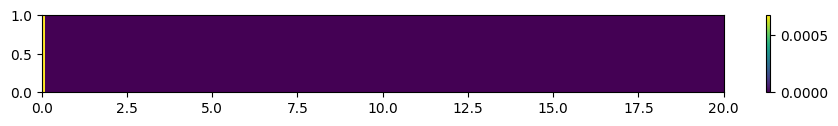

In [4]:
### Initial condition
n0 = np.tile(0.1*Ym*np.exp(-100.0*x),(Ny,1)).T;
### Plot IC
fig, ax = plt.subplots(1,1, figsize=(11,1))
im = ax.pcolormesh(x,y, n0.T, shading='auto') 
fig.colorbar(im, ax=ax)

In [5]:
### ODE approximation of RHS of PDE upon spatial discretisation (finite volume scheme)

def odeRHSeps(t,sol):
    global Diffx, Diffy, r, k, Nx, Ny, dx, dy, x, y
    
    # Reshape sol into n(x,y), Integrate n to obtain rho
    n = np.reshape(sol,(Nx,Ny));
    rho = dy*np.sum(n,axis=1);
    
    # Phenotype-dependent diffusion coefficient D(y) = Dx*y
    Dxy = np.tile(Diffx*y,(Nx,1)); 
    Dxy_mid = 0.5*(Dxy[0:-1,:]+Dxy[1:,:]); # Require approximation at grid cell interfaces in x
    
    # Flux in physical (flx) and phenotype (fly) space, at grid cell interfaces
    flx = np.zeros((Nx+1,Ny)); # This gives also zeroflux BCs at x=0 and x=Xm
    flx[1:-1,:] = Dxy_mid*(n[1:,:]-n[0:-1,:])/dx;
    fly = np.zeros((Nx,Ny+1)); # This gives also zeroflux BCs at y=0 and y=1
    fly[:,1:-1] = Diffy*(n[:,1:]-n[:,0:-1])/dy;
    
    # Flux contributions from spatial movement and phenotypic changes
    dflux = (flx[1:,:]-flx[:-1,:])/dx + (fly[:,1:]-fly[:,:-1])/dy;
    
    # Cell proliferation and death, here F=n*R with R=r*(1-y-rho)
    kinetics = n*( r*(np.ones((Nx,Ny))-np.tile(y,(Nx,1))) - k*np.tile(rho,(Ny,1)).T );
    
    # Store RHS of ODE system obtained via the MOL in dndt
    dndt = dflux + kinetics;
    
    # Return dndt as vector
    return np.reshape(dndt,(Nx*Ny,)); 

In [6]:
### Function to plot travelling wave solution

def plot_TW(n,t):
    global Nx, Ny, dx, dy, x, y, Xm
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(11, 4))
    im = ax1.pcolormesh(x,y,n.T,shading='auto') 
    fig.colorbar(im,ax=ax1,orientation='vertical',label='n(x,y)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(f'$n(t,x,y)$ at time t = {t}')
    rho = dy*np.sum(n,axis=1);
    ax2.plot(x, rho, 'b-', linewidth=2)
    ax2.set_xlabel('x')
    ax1.set_xlim([0, Xm])
    ax2.set_title(f'$\\rho(t,x)$ at time t = {t}')
    fig.subplots_adjust(hspace=1) 
    plt.draw()
    plt.pause(0.1)

t = 0.0


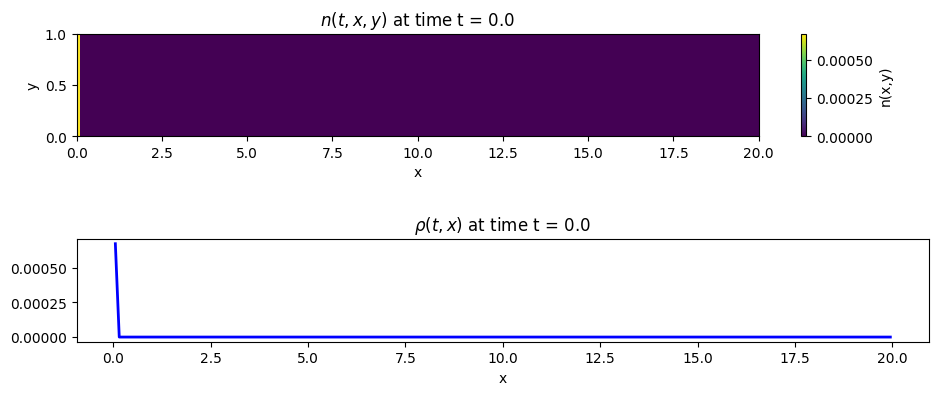

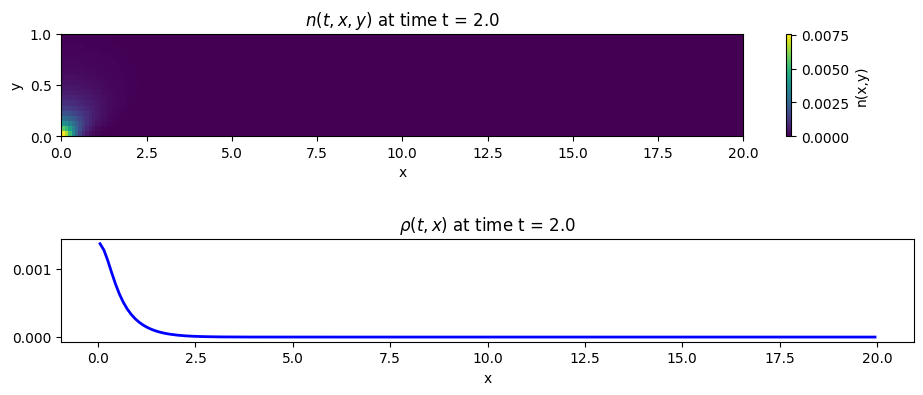

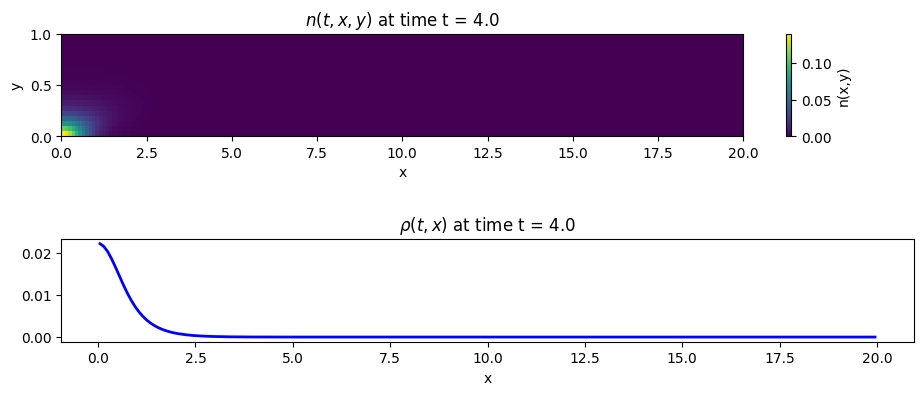

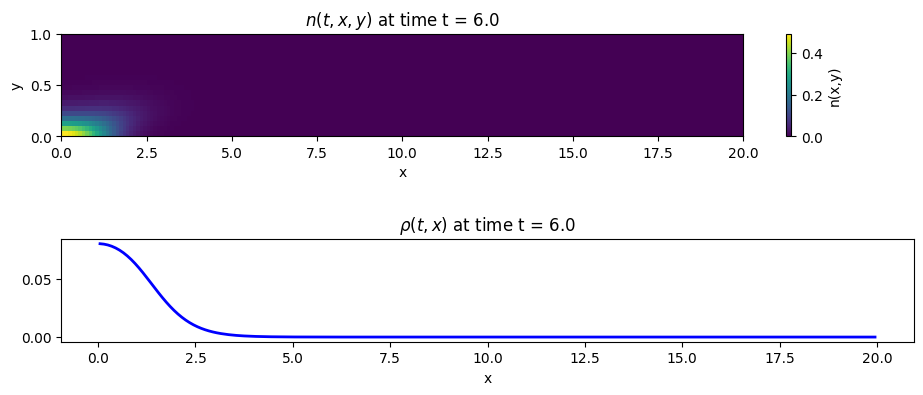

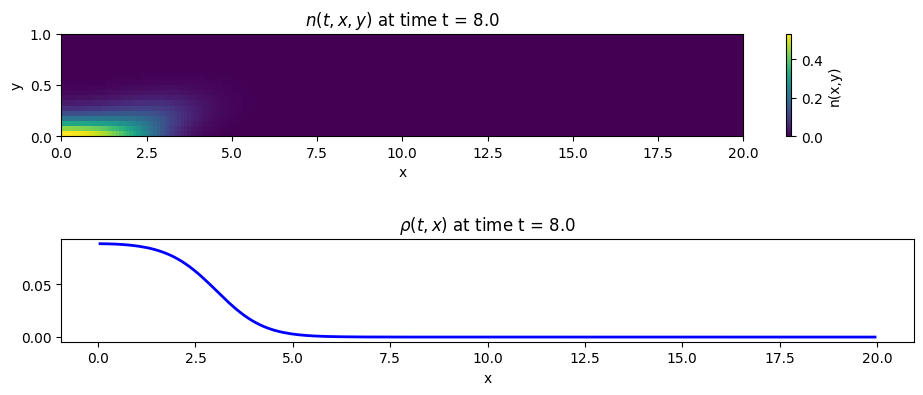

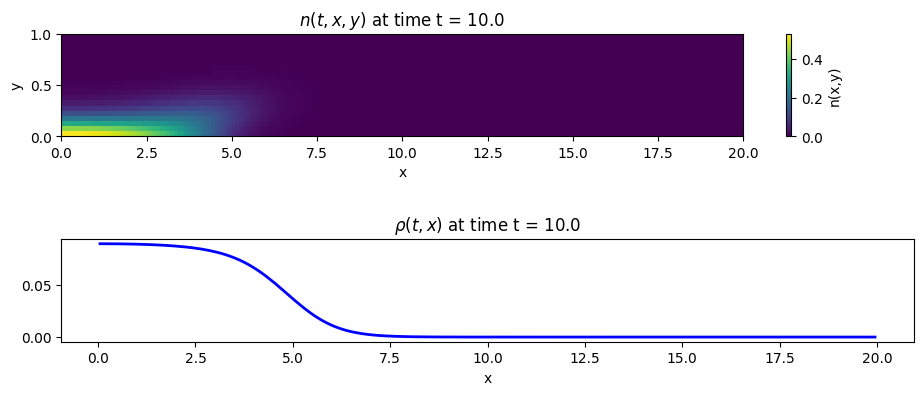

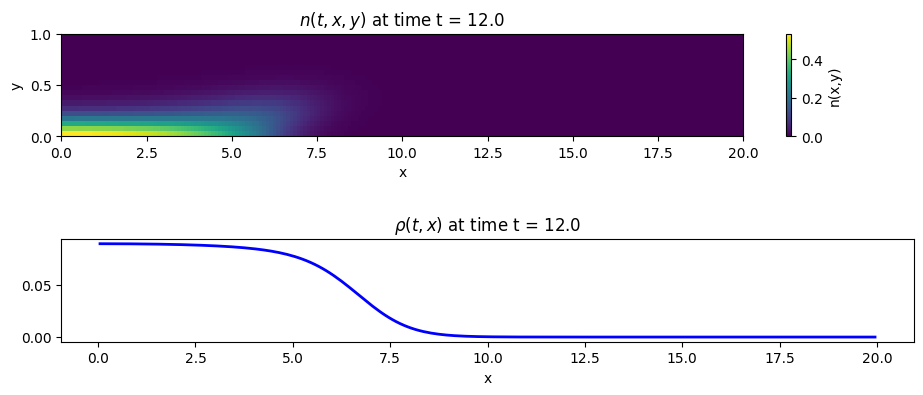

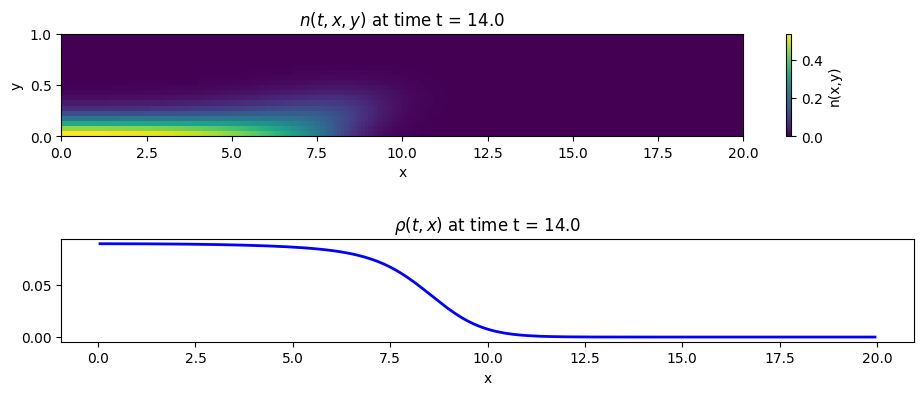

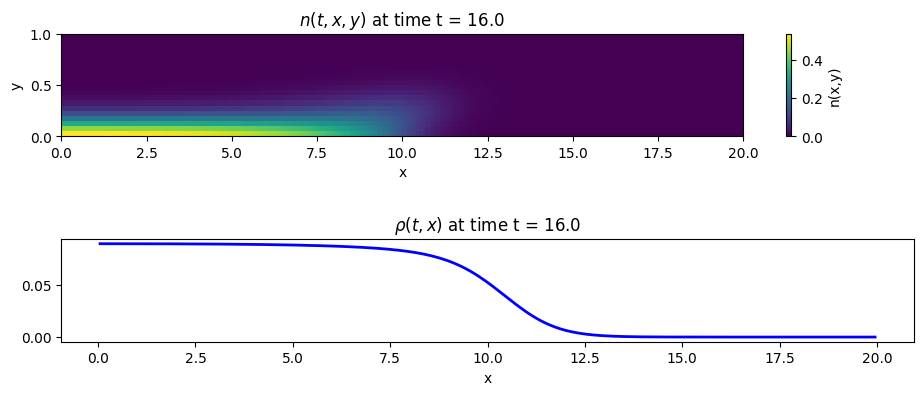

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/integrate/_ivp/bdf.py:415: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


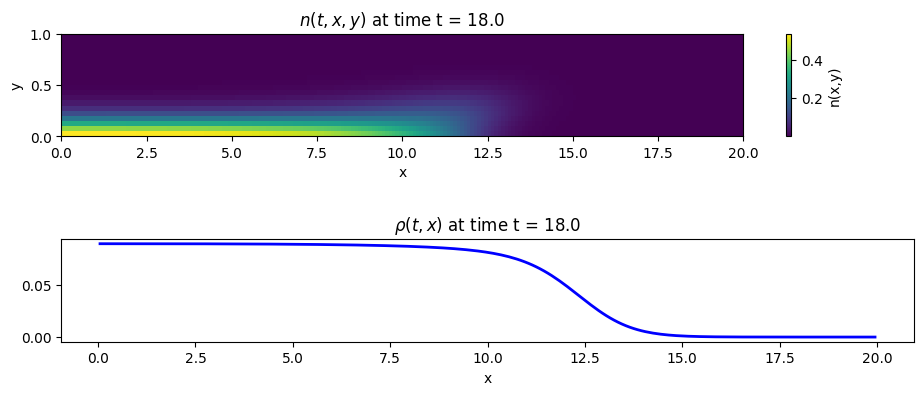

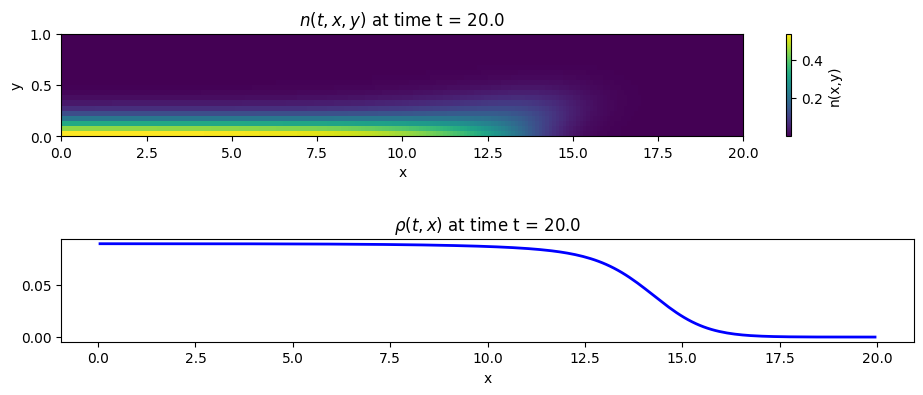

In [7]:
### Solve the PDE using the Method of Lines

# Choose time span for simulations
tend = 20.0;  # End time
tstore = np.linspace(0,tend,11); # Times at which to store the solution
# Initialise storing variables
nsaved = np.zeros((Nx,Ny,tstore.size));
nsaved[:,:,0] = n0;
# Initialise plot
print(f't = {tstore[0]}')
plot_TW(n0,tstore[0])

# Iterate in time 
n = n0;
for i in range(tstore.size-1):
    # Re-shape initial condition for time iteration of vectorised system
    n = np.reshape(n,(Nx*Ny,));
    # Solve ODE system
    solution = solve_ivp(
        odeRHSeps,                # RHS of the ODE system (vectorized)
        (tstore[i],tstore[i+1]),  # Time interval
        n,                        # Initial conditions (vectorised)
        method = 'RK45',          # Integrator method (explicit, adaptive time-step)
#         method = 'BDF',         # Integrator method (implicit)
        rtol = 1e-8,              # Relative tolerance
        atol = 1e-8,              # Absolute tolerance
        vectorized = True         # Use vectorized mode
    )
    sol = solve_ivp(odeRHSeps,(tstore[i],tstore[i+1]),n,method='BDF',rtol=1e-8,atol=1e-8)
    n = np.reshape(sol.y[:,-1],(Nx,Ny));
    nsaved[:,:,i+1] = n;
    plot_TW(n,tstore[i+1]) # Plot solution